In [58]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import soundfile as sf
import matplotlib.patches as patch
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.io import wavfile
import time
import os
import shutil
from skimage import io
from skimage.color import rgb2gray,rgba2rgb
#https://github.com/iver56/audiomentations ?
%matplotlib inline
CC_ROOT=Path("D:\\KidElectric\\rfcx_kaggle") #Cookiecutter datascience-style project
CC_DATA_OUT=CC_ROOT.joinpath('data').joinpath('interim')

DATA_ROOT = CC_ROOT.joinpath('data')
TRAIN_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('train')#Update to point to cookiecutter data/raw/train
TEST_AUDIO_ROOT = DATA_ROOT.joinpath('raw').joinpath('test')#Update to point to cookiecutter data/raw/test


df_train = pd.DataFrame({
    "recording_id": [path.stem for path in TRAIN_AUDIO_ROOT.glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in TEST_AUDIO_ROOT.glob("*.flac")],
})

df_tp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_tp.csv')).set_index('recording_id')

df_fp=pd.read_csv(CC_ROOT.joinpath('references').joinpath('train_fp.csv')).set_index('recording_id')


In [6]:
class params:
    """
    Parameters used for generating spectrograms from audio data
    """
    sr = 48000 #sampling rate

    # Melspectrogram
    n_mels = 128
    fmin = 80
    fmax = 14000  
    n_fft=2048
    hop_length = 512
    


def has_tp_fp(rec,df_tp,df_fp):
    #Many recordings have both tp and fp data labeled.
    has_tp=False
    has_fp=False
    if rec in df_tp.index:
        has_tp = True
    if rec in df_fp.index:
        has_fp = True
    return has_tp, has_fp

def clip_info(rec,df):
    keep={'species_id':[],'t_min':[],'t_max':[]}
    for key in df.keys():
        if key in keep.keys():
            if isinstance(df[key][rec],pd.core.series.Series):
                keep[key]=[val for val in df[key][rec].values]
            else:
                keep[key].append(df[key][rec])
    return keep

def clip_identity(rec,df_tp,df_fp,start,stop):
    out={'tp_spec':[],'tp':0,
         'fp_spec':[],'fp':0}
    has_fp=False
    has_tp=False
    if rec in df_tp.index:
        info = clip_info(rec,df_tp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_tp=True
                out['tp_spec'].append(spec)
                out['tp']+=1
    
    if rec in df_fp.index:
        info = clip_info(rec,df_fp)
        for i,spec in enumerate(info['species_id']):
            t_min=info['t_min'][i]
            t_max=info['t_max'][i]
            overlap=(t_min < stop and t_min >= start) or (t_max >= start and t_max < stop)
            if overlap == True:
                has_fp=True
                out['fp_spec'].append(spec + 24)
                out['fp']+=1   
    return out


        


In [42]:
#1) Remove any TP clips where true positive species audio probably too short ( < 0.5 seconds)
# (Except if species == 14, because this species often truly is less than 0.5s.)
params.clip_dur=6 # second chunks
params.min_dur=0.5 #seconds
resume=0
use_df=df_train
use_root=TRAIN_AUDIO_ROOT
params.dest=DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp').joinpath('too_short')
params.use_root=use_root

if params.dest.exists() == False:
    os.mkdir(params.dest)
imgs=[png for png in params.dest.parent.glob('TP*.png')]
for ii,fn in enumerate(imgs):
    img=fn.parts[-1]
    spec=img.split('_')[1]
    if spec != '14': #All true clip durs < 0.5s are species 14
        rec=img.split('_')[2]
        rec_part=img.split('_')[3].split('.')[0]
        clip_start=float(rec_part)*params.clip_dur
        clip_stop= clip_start + params.clip_dur
        info = clip_info(rec,df_tp)
        for i,s in enumerate(info['species_id']):
            if s == int(spec):
                t_min=info['t_min'][i]
                t_max=info['t_max'][i]
                if (t_max > clip_start) and (t_min < clip_stop):
                    #This call is within this clip.
                    if ((t_max - clip_start) < params.min_dur) or ((clip_stop - t_min) < params.min_dur):
                        #But only the very end or beginning of the call is in the clip
                        shutil.move(str(fn),str(params.dest)) #Move to a separate folder
                        print('%d) %s is %1.3f s == too short!' % (ii,img,np.min([(clip_stop - t_min),(t_max - clip_start)])))


4) TP_0_067f49f8b_9.png is 0.091 s == too short!
7) TP_0_157a50231_5.png is 0.213 s == too short!
9) TP_0_251737ef0_5.png is 0.069 s == too short!
33) TP_0_97630c03d_1.png is 0.133 s == too short!
39) TP_0_a54894b33_4.png is 0.219 s == too short!
49) TP_0_e25933b0a_2.png is 0.368 s == too short!
50) TP_0_e25933b0a_3.png is 0.427 s == too short!
52) TP_0_f5e6456f0_6.png is 0.331 s == too short!
53) TP_0_f5e6456f0_7.png is 0.464 s == too short!
59) TP_10_055d22517_7.png is 0.416 s == too short!
86) TP_10_7764cbbfd_0.png is 0.288 s == too short!
90) TP_10_7ab084435_3.png is 0.262 s == too short!
108) TP_10_d5163b4ef_0.png is 0.445 s == too short!
113) TP_10_db34c4a5d_5.png is 0.436 s == too short!
115) TP_10_dfa6a4a64_2.png is 0.260 s == too short!
123) TP_10_f5c3420f6_5.png is 0.447 s == too short!
125) TP_11_0275e127d_1.png is 0.001 s == too short!
128) TP_11_0295e3234_1.png is 0.298 s == too short!
135) TP_11_215bb7a8d_7.png is 0.138 s == too short!
140) TP_11_373f470c4_0.png is 0.253 

Text(0.5, 0, 'Species')

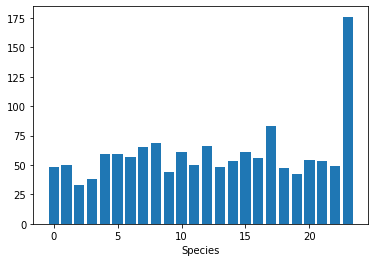

In [56]:
#How many examples of each TP are there?
src=params.dest=DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
imgs=[png for png in src.glob('TP*.png')]
counts=np.zeros((24,))
for ii,fn in enumerate(imgs):
    img=fn.parts[-1]
    spec=img.split('_')[1]
    counts[int(spec)] += 1
    
# print(counts)
plt.bar(x=range(0,24,1),height=counts);
plt.xlabel('Species');

In [83]:
# 2) Create 50 folders of downsampled clips such that:
# a) There are 15 examples of each TP species, 15 FP, 15 NP (Method 1)

src = DATA_ROOT.joinpath('interim').joinpath('train').joinpath('clip_decomp')
fp_img=[png for png in src.glob('FP*.png')]
np_img=[png for png in src.glob('NP*.png')]

num_spec = 24 #Number of unique species
nf = 50 # Number of folders
rs = 15 # Resampled number

root_dest=DATA_ROOT.joinpath('processed').joinpath('resamp_%d' % rs)
for i in range(nf):
    dest=root_dest.joinpath(str(i))
    if dest.exists() == False:
        os.makedirs(dest)
    print('Copying to folder %d.' % i)
    #Resample and move FP:
    fp_rs=np.random.choice(fp_img,size=rs,replace=False)
    for fn in fp_rs:
        p=fn.parts[-1].split('.')[0]
        pp=p.split('_')
        newfn=''
        for x in range(len(pp)):
            if x==1:
                newfn=newfn + '_' + '99'
            else:
                newfn=newfn + '_' + pp[x]
        newfn=newfn[1:] + '.png'
        print('\t%s' % newfn)
        shutil.copy(fn,dest.joinpath(newfn))
        
    # Resample and move NP:
    np_rs=np.random.choice(np_img,size=rs,replace=False)
    print('\t Copying %d NP...' % rs)
    for fn in np_rs:        
        shutil.copy(fn,dest)
        
    print('\t Copying %d of each TP...' % rs)
    for ii in range(num_spec):
        print('\t\t%d...' % ii)
        tp_img=[png for png in src.glob('TP_%d*.png' % ii)]
        tp_rs= np.random.choice(tp_img,size=rs,replace=False)
        for fn in tp_rs:        
            shutil.copy(fn,dest)

Copying to folder 0.
	FP_99_a916ebb05_6.png
	FP_99_9547bef0c_8.png
	FP_99_0effcf241_6.png
	FP_99_4e49040df_6.png
	FP_99_ecb326f94_5.png
	FP_99_26ae2763d_1.png
	FP_99_caf300f6f_5.png
	FP_99_9a6535583_2.png
	FP_99_4e5702ed7_8.png
	FP_99_5e94a23dd_6.png
	FP_99_44f4e69f6_9.png
	FP_99_87daaa880_9.png
	FP_99_ea7da0899_9.png
	FP_99_23adb9473_4.png
	FP_99_66c798e69_7.png
	 Copying 15 NP...
	 Copying 15 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 1.
	FP_99_5df14e9e7_1.png
	FP_99_0a9143370_2.png
	FP_99_73abadb47_9.png
	FP_99_06d95a7e8_1.png
	FP_99_8487fa506_3.png
	FP_99_1679e323d_5.png
	FP_99_d03a7b4f8_2.png
	FP_99_5c9a45273_6.png
	FP_99_d94762e23_1.png
	FP_99_5af2b2a0c_1.png
	FP_99_3b4c751d3_6.png
	FP_99_ccd0a0bff_8.png
	FP_99_e333236af_7.png
	FP_99_a00811313_9.png
	FP_99_31298d8d7_4.png
	 Copying 15 NP...
	 Copying 15 of each 

		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 14.
	FP_99_06c44d203_2.png
	FP_99_fb01fdcea_4.png
	FP_99_b64238c47_4.png
	FP_99_e3da230ab_5.png
	FP_99_b000e1964_2.png
	FP_99_4de8a9cc1_9.png
	FP_99_aedfcfe60_3.png
	FP_99_7675c01d1_4.png
	FP_99_7fa24d225_4.png
	FP_99_15ec6a03d_1.png
	FP_99_1a0846177_7.png
	FP_99_b8864c158_0.png
	FP_99_aeb0f61bf_8.png
	FP_99_0a8974fbc_4.png
	FP_99_1171e7dfa_6.png
	 Copying 15 NP...
	 Copying 15 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 15.
	FP_99_2b60aa72c_2.png
	FP_99_f25a5f303_8.png
	FP_99_9b5bdb9bb_4.png
	FP_99_3d6659ada_5.png
	FP_99_3c48d80aa_0.png
	FP_99_6dc1f9567_3.png
	FP_99_883db48e7_7.png
	FP_99_e8b209030_2.png
	FP_99_dc1fcc4d0_9.png
	FP_99_3f04a523f_1.png
	FP_99_ef0aaa0b3_8.png
	FP_99_af95

	 Copying 15 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 28.
	FP_99_966736b59_9.png
	FP_99_dde374007_7.png
	FP_99_2d805f006_0.png
	FP_99_f5226c724_7.png
	FP_99_57e8854f7_9.png
	FP_99_eec8513cf_9.png
	FP_99_e20f763e1_1.png
	FP_99_3f5f4aa9a_7.png
	FP_99_1db9c9a80_8.png
	FP_99_906fc22b6_3.png
	FP_99_32f8c551e_7.png
	FP_99_b1f873abc_6.png
	FP_99_c3fb678a6_2.png
	FP_99_a40d19a3d_2.png
	FP_99_9c86d718d_8.png
	 Copying 15 NP...
	 Copying 15 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 29.
	FP_99_b2db8eae9_6.png
	FP_99_32f8c551e_6.png
	FP_99_6093f0100_1.png
	FP_99_47ff7542e_5.png
	FP_99_c7dc9f7f4_3.png
	FP_99_dc0075e9c_0.png
	FP_99_03971ab79_0.png
	FP_99_9b59cb

	FP_99_86de74a7c_1.png
	FP_99_3abb75faf_2.png
	FP_99_ac7ded692_2.png
	FP_99_bb76ca250_3.png
	 Copying 15 NP...
	 Copying 15 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 42.
	FP_99_02a9de85e_8.png
	FP_99_9553e7f3c_2.png
	FP_99_258c31cf6_0.png
	FP_99_5c22f5f77_2.png
	FP_99_0a4e7e350_4.png
	FP_99_150cf1c58_5.png
	FP_99_a227d1315_0.png
	FP_99_c10546a22_4.png
	FP_99_2015272b9_5.png
	FP_99_7ea9d320a_7.png
	FP_99_20015050f_1.png
	FP_99_e80890ff7_1.png
	FP_99_8c7648ac2_0.png
	FP_99_d0ea4e8aa_8.png
	FP_99_e34ea9272_4.png
	 Copying 15 NP...
	 Copying 15 of each TP...
		0...
		1...
		2...
		3...
		4...
		5...
		6...
		7...
		8...
		9...
		10...
		11...
		12...
		13...
		14...
		15...
		16...
		17...
		18...
		19...
		20...
		21...
		22...
		23...
Copying to folder 43.
	FP_99_00ad36516_4.png
	FP_99_9b532eb80_5.png
	FP_99_c1e3072db_

In [77]:
b=np.random.choice(fp_img,size=rs,replace=False).transpose()
b

array([WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_32_9cb5f0d5f_9.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_41_457fdb9b8_2.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_38_e6a9fcf06_2.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_27_a2441a74b_6.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_34_c9d617218_4.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_33_b84649a88_0.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_47_6f423ed00_4.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_37_e8b209030_1.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_decomp/FP_27_25d81e0f5_2.png'),
       WindowsPath('D:/KidElectric/rfcx_kaggle/data/interim/train/clip_de